![Image](https://sawaed19.net/wp-content/uploads/2021/01/700600p546EDNmainimg-process-change-management1.jpg)

[Image Source](https://sawaed19.net/en/event/workshop-youth-for-change/)

# Introduction

Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! 😊

The objective of this notebook is to explore the changes in data science over the years. Therefore, we worked on two differents dataset that are [kaggle_survey_2021](https://www.kaggle.com/c/kaggle-survey-2021) and [kaggle_survey_2020](https://www.kaggle.com/c/kaggle-survey-2020/overview). Kaggle survey 2020 has 39+ questions, 20,036 responses and survey 2021 has 42+ questions, 25,973 responses. 

The notebook consists of 5 parts.
1. Introduction
2. Data Preparation
3. Data Cleaning
4. Data Analysis
5. Conclusion

In the introduction part, we started simply importing libraries and datasets.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.simplefilter("ignore")
sns.set()

df21 = pd.read_csv('../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv')
df20 = pd.read_csv('../input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')

In [2]:
print(df20.shape, df21.shape)

(20037, 355) (25974, 369)


In [3]:
print(df20.columns)
print(df21.columns)

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3',
       ...
       'Q35_B_Part_2', 'Q35_B_Part_3', 'Q35_B_Part_4', 'Q35_B_Part_5',
       'Q35_B_Part_6', 'Q35_B_Part_7', 'Q35_B_Part_8', 'Q35_B_Part_9',
       'Q35_B_Part_10', 'Q35_B_OTHER'],
      dtype='object', length=355)
Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3',
       ...
       'Q38_B_Part_3', 'Q38_B_Part_4', 'Q38_B_Part_5', 'Q38_B_Part_6',
       'Q38_B_Part_7', 'Q38_B_Part_8', 'Q38_B_Part_9', 'Q38_B_Part_10',
       'Q38_B_Part_11', 'Q38_B_OTHER'],
      dtype='object', length=369)


# Data Preparation

In this part, we created 3 functions that are used for simplification the datasets. 

In the datasets, some questions have more than one column and function **group_cols** is used for grouping the questions. For example, Q24 is one group, and Q12_Part_1, Q12_Part_2, Q12_Part_3, Q12_OTHER are also one group. 

Function **part_cols_convert** is written for converting the questions that have more than one column to one column. For instance, this function converts Q12_Part_1, Q12_Part_2, Q12_Part_3, Q12_OTHER to Q12 column. 

The last function is **dict_preparation** that is used for matching the same question in 2020 and 2021. Of course in the datasets, some questions mean are the same but the questions are different. We solved that kind of problem with manual correction. For example, Q12 is "Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice - GPUs" in 2020 and "Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice -  NVIDIA GPUs" in 2021

After all preparation, we combined  survey 2020 and 2021 by function **prepare_data**.

In [4]:
def group_cols(df):
    cols = df.columns
    
    col_part = []
    for col in cols:
        if '_' in col:
            col_part.append(col)
    
    cols_1 = list(set(cols) - set(col_part))
    
    temp_df = pd.DataFrame(col_part)
    temp_df['question'] = temp_df[0].str.split('_').str[0]
    temp_group = temp_df.groupby('question')[0]
    
    cols_2 = []
    for name, group in temp_group:
        if len(group) > 1:
            cols_2.append(list(group.values))
    
    return list(cols_1 + cols_2)

In [5]:
def part_cols_convert(df):
    cols = df.columns
    
    col_part = []
    for col in cols:
        if '_' in col:
            col_part.append(col)
    
    temp_df = pd.DataFrame(col_part)
    temp_df['question'] = temp_df[0].str.split('_').str[0]
    temp_group = temp_df.groupby('question')[0]
    
    cols_2 = []
    for name, group in temp_group:
        if len(group) > 1:
            cols_2.append(list(group.values))
    
    part_df_list = []
    for cols in cols_2:
        part_df = pd.DataFrame()
        new_col = cols[0].split('_')[0]
        
        values_list = []
        for col in cols:
            str_value = df.loc[0, col].split('-')[-1]
            count_num = df[col].value_counts()[0]
            values = [str_value for i in range(count_num)]
            values_list.extend(values)
        
        part_df[new_col] = values_list
        part_df_list.append(part_df)
    
    df_parts = pd.concat(part_df_list, 1)
    return df_parts

In [6]:
def dict_preparation(question_2020, question_2021, df20, df21):
    same_questions_dict = {}
    question_mean_dict = {}

    for c_20 in question_2020:
        if type(c_20) is list:
            c_20 = c_20[0]
            question_mean_dict[c_20.split('_')[0]] = df20.loc[0, c_20]
            #print('c_20:', c_20 , df20.loc[0, c_20])
        else:
            question_mean_dict[c_20] = df20.loc[0, c_20]
        q_20 = df20.loc[0, c_20]

        for c_21 in question_2021:
            if type(c_21) is list:
                c_21 = c_21[0]
            q_21 = df21.loc[0, c_21]
            #print('c_21:', c_21, q_21)
            if q_21 == q_20:
                if '_' in c_20:
                    if '_' in c_21:
                        same_questions_dict[c_20.split('_')[0]] = c_21.split('_')[0]
                    else:
                        same_questions_dict[c_20.split('_')[0]] = c_21
                else:
                    if '_' in c_21:
                        same_questions_dict[c_20] = c_21.split('_')[0]
                    else:
                        same_questions_dict[c_20] = c_21
                break
    return same_questions_dict, question_mean_dict

In [7]:
df20_parts = part_cols_convert(df20)
df21_parts = part_cols_convert(df21)

question_2020 = group_cols(df20)
question_2021 = group_cols(df21)

same_questions_dict, question_mean_dict = dict_preparation(question_2020, question_2021, df20, df21)

print(same_questions_dict)
print(question_mean_dict)

{'Q21': 'Q22', 'Q2': 'Q2', 'Q20': 'Q21', 'Q3': 'Q3', 'Q32': 'Q35', 'Q6': 'Q6', 'Q8': 'Q8', 'Q25': 'Q26', 'Q30': 'Q33', 'Q11': 'Q11', 'Q5': 'Q5', 'Q4': 'Q4', 'Q22': 'Q23', 'Q24': 'Q25', 'Q15': 'Q15', 'Q1': 'Q1', 'Q13': 'Q13', 'Time from Start to Finish (seconds)': 'Time from Start to Finish (seconds)', 'Q38': 'Q41', 'Q10': 'Q10', 'Q14': 'Q14', 'Q16': 'Q16', 'Q17': 'Q17', 'Q18': 'Q18', 'Q19': 'Q19', 'Q23': 'Q24', 'Q26': 'Q27', 'Q29': 'Q32', 'Q31': 'Q34', 'Q33': 'Q36', 'Q34': 'Q37', 'Q35': 'Q38', 'Q37': 'Q40', 'Q39': 'Q42', 'Q7': 'Q7', 'Q9': 'Q9'}
{'Q21': 'Approximately how many individuals are responsible for data science workloads at your place of business?', 'Q2': 'What is your gender? - Selected Choice', 'Q20': 'What is the size of the company where you are employed?', 'Q3': 'In which country do you currently reside?', 'Q32': 'Which of the following business intelligence tools do you use most often? - Selected Choice', 'Q6': 'For how many years have you been writing code and/or progra

In [8]:
print(question_2020)
print(question_2021)

['Q21', 'Q2', 'Q20', 'Q3', 'Q32', 'Q6', 'Q8', 'Q25', 'Q30', 'Q11', 'Q5', 'Q4', 'Q22', 'Q24', 'Q15', 'Q1', 'Q13', 'Time from Start to Finish (seconds)', 'Q38', ['Q10_Part_1', 'Q10_Part_2', 'Q10_Part_3', 'Q10_Part_4', 'Q10_Part_5', 'Q10_Part_6', 'Q10_Part_7', 'Q10_Part_8', 'Q10_Part_9', 'Q10_Part_10', 'Q10_Part_11', 'Q10_Part_12', 'Q10_Part_13', 'Q10_OTHER'], ['Q12_Part_1', 'Q12_Part_2', 'Q12_Part_3', 'Q12_OTHER'], ['Q14_Part_1', 'Q14_Part_2', 'Q14_Part_3', 'Q14_Part_4', 'Q14_Part_5', 'Q14_Part_6', 'Q14_Part_7', 'Q14_Part_8', 'Q14_Part_9', 'Q14_Part_10', 'Q14_Part_11', 'Q14_OTHER'], ['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5', 'Q16_Part_6', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9', 'Q16_Part_10', 'Q16_Part_11', 'Q16_Part_12', 'Q16_Part_13', 'Q16_Part_14', 'Q16_Part_15', 'Q16_OTHER'], ['Q17_Part_1', 'Q17_Part_2', 'Q17_Part_3', 'Q17_Part_4', 'Q17_Part_5', 'Q17_Part_6', 'Q17_Part_7', 'Q17_Part_8', 'Q17_Part_9', 'Q17_Part_10', 'Q17_Part_11', 'Q17_OTHER'], ['Q18_Part

In [9]:
from termcolor import colored

diff_questions_20_list = ['Q12_Part_1', 'Q27_A_Part_1', 'Q27_B_Part_1', 'Q28_A_Part_1', 'Q28_B_Part_1', 'Q36_Part_1']
diff_questions_21_list = ['Q12_Part_1', 'Q27_A_Part_1', 'Q27_B_Part_1', 'Q28', 'Q36_A_Part_1', 'Q36_B_Part_1']
more_questions_list = ['Q40_Part_1', 'Q41', 'Q42_Part_1']

print(colored('1) ', 'green'), df20.loc[0, 'Q12_Part_1'], ' - ', df21.loc[0, 'Q12_Part_1'])
print(colored('2) ', 'green'), df20.loc[0, 'Q27_A_Part_1'], ' - ', df21.loc[0, 'Q27_A_Part_1'])
print(colored('3) ', 'green'), df20.loc[0, 'Q27_B_Part_1'], ' - ', df21.loc[0, 'Q27_B_Part_1'])

print(colored('3.5) ', 'green'), df20.loc[0, 'Q26_A_Part_1'], ' - ', df21.loc[0, 'Q27_A_Part_1'])

print(colored('4) ', 'red'), df20.loc[0, 'Q28_A_Part_1'], ' - ', df21.loc[0, 'Q28'])
print(colored('5) ', 'red'), df20.loc[0, 'Q28_B_Part_1'], ' - ', df21.loc[0, 'Q28'])
print(colored('6) ', 'red'), df20.loc[0, 'Q36_Part_1'], ' - ', df21.loc[0, 'Q36_A_Part_1'])
print(colored('7) ', 'red'), df20.loc[0, 'Q36_Part_1'], ' - ', df21.loc[0, 'Q36_B_Part_1'])

print(colored('8) ', 'blue'), df21.loc[0, 'Q40_Part_1'])
print(colored('9) ', 'blue'), df21.loc[0, 'Q41'])
print(colored('10) ', 'blue'), df21.loc[0, 'Q42_Part_1'])

same_questions_dict['Q12'] = 'Q12'

1)  Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice - GPUs  -  Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice -  NVIDIA GPUs 
2)  Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice -  Amazon EC2   -  Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected Choice -  Amazon Web Services (AWS) 
3)  In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products? (Select all that apply) - Selected Choice -  Amazon EC2   -  Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice -  Amazon Web Services (AWS) 
3.5)  Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) - Selected 

In [10]:
not_exist_2020 = ['Q27', 'Q28', 'Q36']
not_exist_2021 = ['Q20', 'Q28', 'Q29', 'Q30', 'Q31', 'Q39']

print(colored('1) 2020 --- ', 'blue'), df20.loc[0, 'Q27_A_Part_1'])
print(colored('2) 2020 --- ', 'blue'), df20.loc[0, 'Q28_A_Part_1'])
print(colored('3) 2020 --- ', 'blue'), df20.loc[0, 'Q36_Part_1'])
print()
print(colored('1) 2021 --- ', 'red'), df21.loc[0, 'Q20'])
print(colored('2) 2021 --- ', 'red'), df21.loc[0, 'Q28'])
print(colored('3) 2021 --- ', 'red'), df21.loc[0, 'Q29_A_Part_1'])
print(colored('4) 2021 --- ', 'red'), df21.loc[0, 'Q30_A_Part_1'])
print(colored('5) 2021 --- ', 'red'), df21.loc[0, 'Q31_A_Part_1'])
print(colored('6) 2021 --- ', 'red'), df21.loc[0, 'Q39_Part_1'])

same_questions_dict['Q27'] = 'Q29'
same_questions_dict['Q28'] = 'Q31'
same_questions_dict['Q36'] = 'Q39'

1) 2020 ---  Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice -  Amazon EC2 
2) 2020 ---  Do you use any of the following machine learning products on a regular basis? (Select all that apply) - Selected Choice -  Amazon SageMaker 
3) 2020 ---  Where do you publicly share or deploy your data analysis or machine learning applications? (Select all that apply) - Selected Choice -  Plotly Dash 

1) 2021 ---  In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice
2) 2021 ---  Of the cloud platforms that you are familiar with, which has the best developer experience (most enjoyable to use)? - Selected Choice
3) 2021 ---  Do you use any of the following cloud computing products on a regular basis? (Select all that apply) - Selected Choice -  Amazon Elastic Compute Cloud (EC2) 
4) 2021 ---  Do you use any of the following data storage products on a regular basis? (Selec

In [11]:
def prepare_data(same_questions_dict, df20, df21, df20_parts, df21_parts):
    cols_20, cols_21 = [], []
    part_cols_20, part_cols_21 = [], []
    for key in same_questions_dict.keys():
        if key in df20_parts.columns:
            part_cols_20.append(key)
            part_cols_21.append(same_questions_dict[key])
        else:
            cols_20.append(key)
            cols_21.append(same_questions_dict[key])
    
    df20['years'] = 2020
    df21['years'] = 2021
    df20_parts['years'] = 2020
    df21_parts['years'] = 2021
    
    cols_20.append('years')
    cols_21.append('years')
    part_cols_20.append('years')
    part_cols_21.append('years')
    
    temp_df21 = df21[cols_21]
    temp_df21.columns = cols_20
    temp_df21_parts = df21_parts[part_cols_21]
    temp_df21_parts.columns = part_cols_20
    
    df_20_21 = pd.concat([df20[cols_20].loc[1:, :], temp_df21.loc[1:, :]], join='outer')
    df_part_20_21 = pd.concat([df20_parts[part_cols_20].loc[1:, :], temp_df21_parts.loc[1:, :]], join='outer')
    
    return df_20_21, df_part_20_21

In [12]:
df_20_21, df_part_20_21 = prepare_data(same_questions_dict, df20, df21, df20_parts, df21_parts)

print(df_20_21.shape)
print(df_part_20_21.shape)

(46009, 20)
(116578, 22)


# Data Cleaning

Data cleaning is one of the most importants part of data science. As with most datasets, this dataset needs data cleaning. According to my view, some answers were split like 'Product/Project Manager' to 'Program/Project Manager', 'Product Manager' and some answers have been fixed like PostgresSQL to PostgreSQL in 2021. In the below, we tried to match the same answers.

In [13]:
df_20_21_clean = df_20_21.copy()
df_part_20_21_clean = df_part_20_21.copy()

df_20_21_clean['Q6'] = df_20_21_clean['Q6'].str.replace('1-3 years', '1-2 years')
df_20_21_clean['Q30'] = df_20_21_clean['Q30'].str.replace('PostgresSQL', 'PostgreSQL')
df_20_21_clean['Q4'] = df_20_21_clean['Q4'].str.replace('Professional degree', 'Professional doctorate')
df_20_21_clean['Q5'] = df_20_21_clean['Q5'].str.replace('Program/Project Manager', 'Product/Project Manager')
df_20_21_clean['Q5'] = df_20_21_clean['Q5'].str.replace('Product Manager', 'Product/Project Manager')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('$', '')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('300,000-499,999', '300,000-500,000')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('500,000-999,999', '> 500,000')
df_20_21_clean['Q24'] = df_20_21_clean['Q24'].str.replace('>1,000,000', '> 500,000')
df_20_21_clean['Q11'] = df_20_21_clean['Q11'].str.replace('A personal computer / desktop', 'A personal computer or laptop')
df_20_21_clean['Q11'] = df_20_21_clean['Q11'].str.replace('A laptop', 'A personal computer or laptop')

df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace('  Amazon Sagemaker Studio Notebooks ', '  Amazon Sagemaker Studio ')
df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace('\n', '')
df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace(' Google Cloud Datalab Notebooks', ' Google Cloud Datalab')
df_part_20_21_clean['Q10'] = df_part_20_21_clean['Q10'].str.replace(' Google Cloud AI Platform Notebooks ', ' Google Cloud Notebooks (AI Platform / Vertex AI) ')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace('PostgresSQL', 'PostgreSQL')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace('\n', '')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace(' Microsoft Azure SQL Database ', ' Microsoft Azure Data Lake Storage ')
df_part_20_21_clean['Q29'] = df_part_20_21_clean['Q29'].str.replace(' Microsoft Azure Cosmos DB ', ' Microsoft Azure Data Lake Storage ')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace('\n', '')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace('(', '')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(')', '')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google AutoML, H2O Driverless AI', 
                                                        ' Automation of full ML pipelines AutoML')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google Cloud AutoML, H2O Driverless AI', 
                                                        ' Automation of full ML pipelines Cloud AutoML')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google AutoML, H20 Driverless AI', 
                                                        ' Automation of full ML pipelines AutoML')
df_part_20_21_clean['Q33'] = df_part_20_21_clean['Q33'].str.replace(' Automation of full ML pipelines e.g. Google Cloud AutoML, H20 Driverless AI', 
                                                        ' Automation of full ML pipelines Cloud AutoML')
df_part_20_21_clean['Q34'] = df_part_20_21_clean['Q34'].str.replace('  H20 Driverless AI  ', '  H2O Driverless AI  ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Visual Studio / Visual Studio Code ', '  VisualStudio ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('(', '')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace(')', '')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Visual Studio Code VSCode ', '  VisualStudio ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Visual Studio ', '  VisualStudio ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  VisualStudio ', '  Visual Studio / Visual Studio Code ')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace(' Jupyter (JupyterLab, Jupyter Notebooks, etc) ', '  Jupyter Notebook')
df_part_20_21_clean['Q9'] = df_part_20_21_clean['Q9'].str.replace('  Jupyter Notebook', ' Jupyter (JupyterLab, Jupyter Notebooks, etc) ')
df_part_20_21_clean['Q12'] = df_part_20_21_clean['Q12'].str.replace('  Google Cloud TPUs ', ' TPUs')
df_part_20_21_clean['Q12'] = df_part_20_21_clean['Q12'].str.replace('  NVIDIA GPUs ', ' GPUs')
df_part_20_21_clean['Q27'] = df_part_20_21_clean['Q27'].str.replace('  Amazon Elastic Container Service ', '  Amazon Elastic Compute Cloud (EC2) ')
df_part_20_21_clean['Q27'] = df_part_20_21_clean['Q27'].str.replace('  Microsoft Azure Container Instances ', '  Microsoft Azure Virtual Machines ')


#print(df_20_21_clean['Q11'].unique())

# Data Analysis

In this part, we plotted all questions for visual pieces of information. We created 2 functions. 

Function **long_sentences_seperate** is used for visual editing. For instance, if a question or an answer text is so long for plotting, this function splits the text by adding '\n' to the text.

The **barplot_all_cols** function is used for plotting all columns. For color, we selected the 'years' column.

In [14]:
def long_sentences_seperate(sentence, step=10):
    try:
        splittext = sentence.split(" ")
        for x in range(step, len(splittext), step):
            splittext[x] = "\n"+splittext[x].lstrip()
        text = " ".join(splittext)
        return text
    except:
        return sentence

In [15]:
def barplot_all_cols(df, question_mean_dict, df_cols, figsize=(24, 96)):
    response_num_2020 = df20.shape[0]
    response_num_2021 = df21.shape[0]
    
    ncols = 2
    nrows = round(len(df_cols) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    plt.subplots_adjust(hspace=0.3)
    
    index = 0
    for row in range(nrows):
        for col in range(ncols):
            try:
                col_name = df_cols[index]
                question = question_mean_dict[col_name]
                question = long_sentences_seperate(question, step=10)
            except:
                axes[row][col].set_visible(False)
                continue
            
            if col_name == 'Q3':
                selected_countries = df[col_name].value_counts(normalize=True).index[:10]
                temp_df = df[df[col_name].isin(selected_countries)]
                
                temp_df = temp_df.groupby([col_name, 'years']).agg({col_name:'count'})
                temp_df.columns = ['counts']
                temp_df.reset_index(inplace=True)
            else:
                temp_df = df.groupby([col_name, 'years']).agg({col_name:'count'})
                temp_df.columns = ['counts']
                temp_df.reset_index(inplace=True)
            
            temp_df.loc[temp_df['years'] == 2020, 'counts_norm'] = temp_df.loc[temp_df['years'] == 2020, 'counts'] / response_num_2020
            temp_df.loc[temp_df['years'] == 2021, 'counts_norm'] = temp_df.loc[temp_df['years'] == 2021, 'counts'] / response_num_2021
            temp_df[col_name] = temp_df[col_name].apply(lambda x: long_sentences_seperate(x, step=4))
            
            ### Find The Order That Biggest Change to Lowest Change
            count_df = temp_df[col_name].value_counts()
            selected_values = list(count_df[count_df > 1].index)
            clean_temp_df = temp_df[temp_df[col_name].isin(selected_values)]
            changes_list = ((clean_temp_df.loc[clean_temp_df['years'] == 2021, 'counts'].values - clean_temp_df.loc[clean_temp_df['years'] == 2020, 'counts'].values) / 
                            clean_temp_df.loc[clean_temp_df['years'] == 2020, 'counts'].values)
            change_twice_list = []
            for value in changes_list:
                change_twice_list.append(value)
                change_twice_list.append(value)
            clean_temp_df['change'] = change_twice_list
            clean_temp_df.sort_values('change', inplace=True, ascending=False)
            order_list = list(clean_temp_df[col_name].unique())
            temp_df_unique = temp_df[col_name].unique()
            diff_order = list(set(temp_df_unique) - set(order_list))
            if len(diff_order) > 0:
                order_list.extend(diff_order)
            ###
            
            sns.barplot(data=temp_df, x='counts_norm', y=col_name, hue='years', order=order_list, ax=axes[row][col])
            axes[row][col].set_title(question)
            for p in axes[row][col].patches:
                txt = str(p.get_width().round(3))
                txt_x = p.get_width() 
                txt_y = p.get_y() + p.get_height() * 2 / 5
                bar_color = p.get_facecolor()
                try:
                    if bar_color == (0.34705882352941175, 0.4588235294117645, 0.6411764705882353, 1.0):
                        txt_count = str(round(p.get_width() * response_num_2020))
                    elif bar_color == (0.7985294117647057, 0.536764705882353, 0.38970588235294135, 1.0):
                        txt_count = str(round(p.get_width() * response_num_2021))
                except:
                    txt_count = 0
                txt_count_y = p.get_y() + p.get_height() * 4 / 5
                axes[row][col].text(txt_x,txt_y,txt,color=bar_color)
                axes[row][col].text(txt_x,txt_count_y,txt_count,color=bar_color)
            
            index += 1

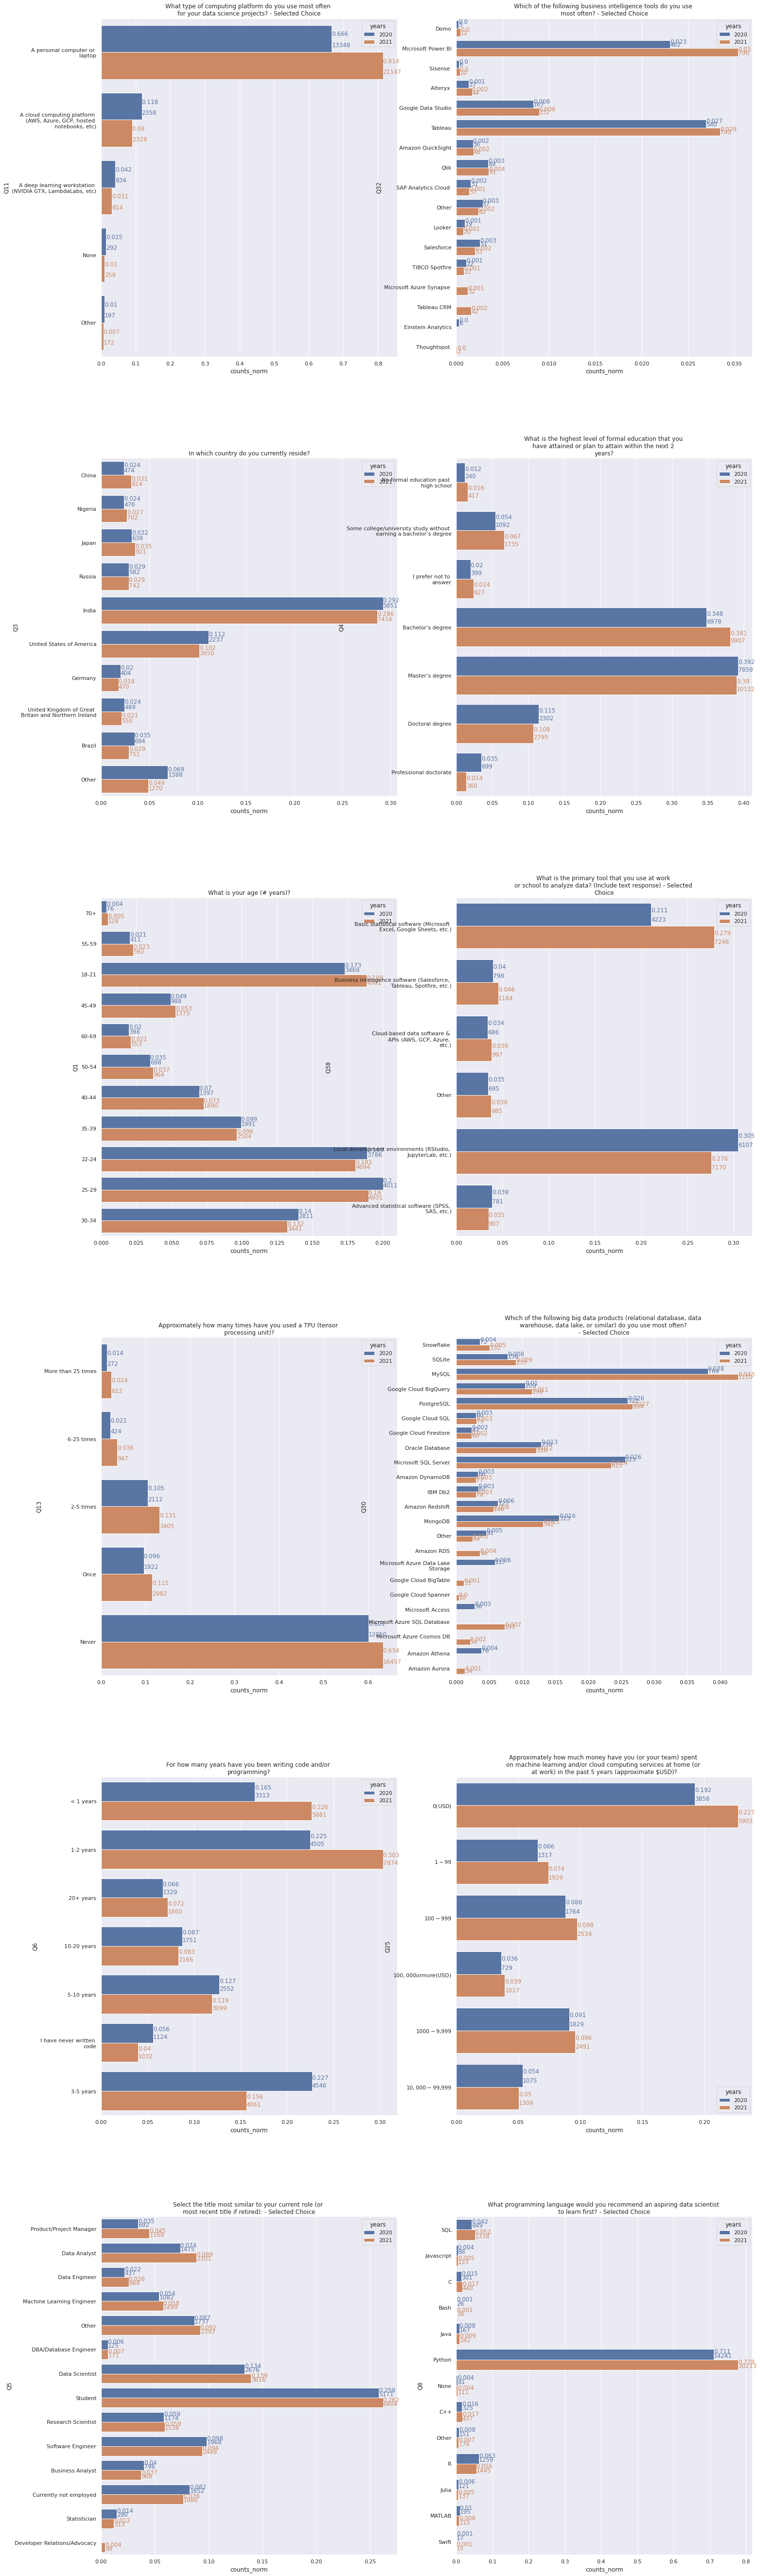

In [16]:
DS_col = ['Q11', 'Q32', 'Q3', 'Q4', 'Q1', 'Q38', 'Q13', 'Q30', 'Q6', 'Q25', 'Q5', 'Q8']

barplot_all_cols(df_20_21_clean, question_mean_dict, DS_col)

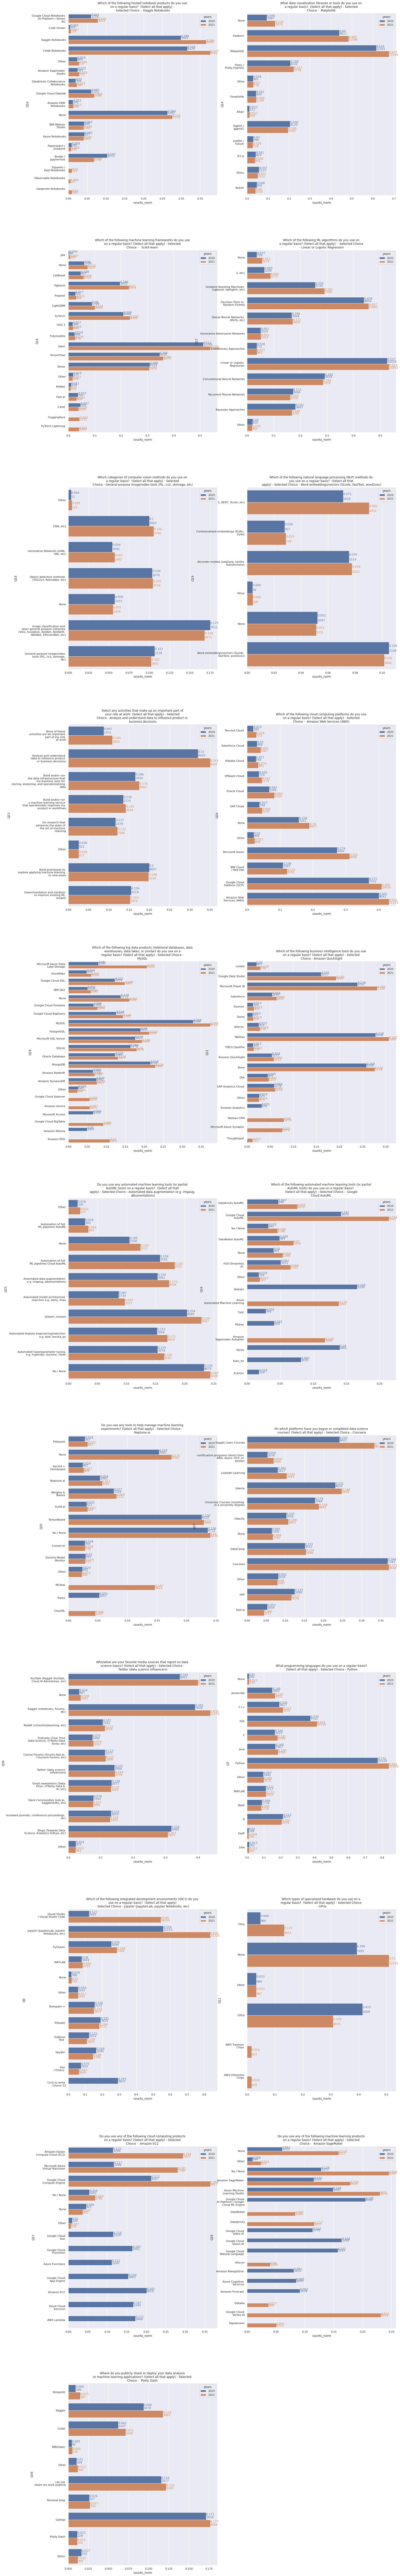

In [17]:
barplot_all_cols(df_part_20_21_clean, question_mean_dict, df_part_20_21_clean.columns, figsize=(24, 192))

# Conclusion
In 2021, all usage of cloud computing increase. The most famous cloud computing tools are AWS, GCP, Microsoft Azure. The cloud computing process will be used more in 2022 ☁️.

Business Intelligence Tools are also increasing. Microsoft Power BI increase 462 to 790 and Tableau increase 540 to 740. We can say Microsoft Power BI will be used much more than Tableau in the future.

In 2020, the most common age was 22–24 in Data Science. Now, it is 18–21. Welcome young Data Scientists 👋. Also 70+ increase from 76 to 128. The range of age of data scientists getting bigger. On the other hand, the answer that is "I have never written code" is decreased even if 18–21 age is increased in 2021. We can say "Code age is decreased" 🔥.
The number of Data Scientists increased around all of the worlds. Most increase in China 🌍.

In the usage of TPU, 2–5 times increase 2012 to 3405, 6–25 increase 424 to 947 and 25+ increase 272 to 612. We can say "We will hear the name of TPU much more in 2022". Usage of GPU decreased from 8309 to 8035 and TPUs increased 960 to 3451. In 2022 TPUs can be more used than GPUs 📱.

Ungraduated and Bachelor's degree increased but Professional doctorate decreased from 699 to 360. That is almost half. This situation can be caused by the Kaggle survey. Maybe data scientists that have Professional doctorates, stoped using Kaggle 📚.

In general, usage of all of the data products increased. Most increase in MySQL. In that article (What Are The Differences Between Data Scientists That Earn 500💲 And 225.000💲 Yearly?), it was also said that databases are so important for data scientists.

In general, all of the jobs increased but Business Analysts and Statisticians can be assumed to be unchanged. Now, we have a new job title that is Developer Relations/Advocacy 💼.

In, Hosted Notebook Products, Binder/JupyterHub decreased from 2072 to 1770 and Kaggle Notebooks increased 5991 to 9506, Colab Notebooks increased 6329 to 9792. The most increase is in Google Cloud Notebooks (AI Platform / Vertex AI) 📓.
All usage of data visualization libraries increased and the most increase is in Seaborn📊 8821 to 12586. In IDEs, all usages of IDEs increased but the most increase is in Visual Studio / Visual Studio Code 2445 to 14150. The second is in Jupyter 11210 to 21720.

In ML Frameworks, Tensorflow, Pytorch, and Xgboost all increased but the most increase in Xgboost 3935 to 5974, CatBoost 957 to 1512, and JAX 84 to 190. Also, we have new selections that are Huggingface and Pytorch Lightning. In Computer Vision, all usage of computer vision algorithms increased but the most increase is in CNN 2003 to 2740 and GAN 1092 to 1492. In Natural Language Processing (NLP), all usage of NLP increased but the most increase is in BERT 1428 to 2351.

Another question is about programing language recommendations. In this question, only Swift decreased. The most increase in SQL. In the use of programming language, Python🐍 is the most famous and the most increase in Javascript 2995 to 4332.
In the question that is about the most important part of work, the most percentage is in analyzing and understanding data to the product or business decisions 6420 to 9107. 35 percent of data scientists gave this answer and the most increase is in the "None of these activities" answer. There can be a new role that is not clear yet in data science.

Automated ML Tools are mostly used in ML pipelines in 2021. Probably it is still will be used ML pipelines in 2022. The most increase is in Databricks AutoML 948 to 1970 and Google Cloud AutoML 2839 to 5567. Also, Google AutoML is the most famous, and Amazon Sagemaker Autopilot, Azure Automate Machine Learning are new in Automated ML Tools ⚙️.

In the question of the course, the most increase is in Kaggle Learn Courses but this data is not trustable because the survey belongs to Kaggle. Other important courses are Certification Programs(AWS, Azure, GCP, etc) increased from 1076 to 1804 and LinkedIn Learning increased from 1617 to 2093. Also, in general, spending money for ml increased 📚.

In the question that is about sharing or deployment, the most famous tool is Github that increased 3434 to 4586. The most increase is in Streamlight 186 to 387, Kaggle 1878 to 3065, and Colab 1247 to 1848.

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! 😊